# Speaker Diarization Evaluation

The diarization outputs and labels are expected to be in RTTM (Rich Transcription Time Marked) format.

The **label** file is a large csv file of stacking label files in RTTM format ending with '.rttm'

The **prediction** files are csv files of individual prediction in RTTM format ending with '.rttm'

[TODO] decide end or start+dur \
[TODO] clean and be consistent of file formats before release



In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import os
import glob
from eval_utils import *

from pyannote.core import Annotation, Segment, Timeline
from pyannote.metrics import diarization

## Prepare data 

prepare ground-truth label

In [72]:
# Change
# AMI corpus
label_file = '/home/fjia/data/ami/eval/AMI/MixHeadset.test.rttm'

# CALLHOME
label_file = '/home/fjia/data/callhome/fullref.rttm'

In [73]:
df = pd.read_csv(label_file, sep=" ", delimiter=None, header=None)
df = df.rename(columns={3: "start", 4: "dur", 7: "speaker"})

label_filenames = set(df[1])

prepare predictions and audio folder

In [74]:
# Change!

# AMI corpus 
# todo add instruction to download ami labels from 
# https://github.com/pyannote/pyannote-audio/tree/master/tutorials/data_preparation/AMI
audio_folder = "/home/fjia/data/ami/ami_audio_preprocessed"
sd_rttm_folder= label_file # change it to actual predictions


# CALLHOME
audio_folder = '/home/fjia/data/callhome/r65_8_1/sid00sg1/data/'
sd_rttm_folder= '/home/fjia/data/callhome/oracle' # change it to actual predictions


In [75]:
prediction_filenames = [os.path.basename(x).split(".rttm")[0] \
                        for x in glob.glob(os.path.join(sd_rttm_folder, "*.rttm"))]
# Take intersection of expected filenames from label file and actual prediction filenames
filenames =  label_filenames & set(prediction_filenames)

print(f"files in either predictions or labels but not both : {label_filenames ^ set(prediction_filenames)}")

files in either predictions or labels but not both : {'iaeu'}


## construct reference and hypothesis for vad evaluation

In [76]:
def sd_construct_per_file(vad_txt_folder, df, filename):
    df_one = df[df[1]==filename].reset_index(drop = True)
    
    vad_file = os.path.join(vad_txt_folder, filename +'.rttm')
    pred = pd.read_csv(vad_file, sep=" ", delimiter=None, header=None).rename(columns={3: "start", 4: "dur", 7: "speaker"})
    
    # construct reference
    reference = Annotation(uri = filename)
    for index, row in df_one.iterrows():
        reference[Segment(row['start'], row['start'] + row['dur'])] = row['speaker']   

    # construct hypothsis
    hypothesis = Annotation(uri = filename)
    for index, row in pred.iterrows():
        hypothesis[Segment(row['start'], row['start'] + row['dur'])] = row['speaker']   
    return reference, hypothesis, df_one

$$ \text{detection error rate} = \frac{(\text{false alarm} + \text{missed detection} + \text{confusion})}{total}$$

In [77]:
metric = diarization.DiarizationErrorRate()
for filename in filenames:
    reference, hypothesis, df_one = sd_construct_per_file(sd_rttm_folder, df, filename)
    metric(reference, hypothesis) # accumulation
        
report = metric.report(display=True)
metric.reset() # reset internal accumulator 

/home/fjia/anaconda3/envs/vad/lib/python3.7/site-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


      diarization error rate    total  correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                         %                       %                                 %                   %
item                                                                                                                                
iabi                    0.00   383.78   383.78  100.00        0.00        0.00             0.00             0.00      0.00      0.00
iajc                    0.00    58.74    58.74  100.00        0.00        0.00             0.00             0.00      0.00      0.00
iapr                    0.00    89.57    89.57  100.00        0.00        0.00             0.00             0.00      0.00      0.00
iakh                    0.00    44.95    44.95  100.00        0.00        0.00             0.00             0.00      0.00      0.00
iajb                    0.00   181.86   181.86  100.00        0.00   

In [78]:
report.columns

MultiIndex([('diarization error rate', '%'),
            (                 'total',  ''),
            (               'correct',  ''),
            (               'correct', '%'),
            (           'false alarm',  ''),
            (           'false alarm', '%'),
            (      'missed detection',  ''),
            (      'missed detection', '%'),
            (             'confusion',  ''),
            (             'confusion', '%')],
           )

In [79]:
report.iloc[[-1]]

diarization error rate      total    correct        false alarm       \
                           %                            %                %   
item                                                                         
TOTAL                    0.0  64935.051  64935.051  100.0         0.0  0.0   

      missed detection      confusion       
                          %              %  
item                                        
TOTAL              0.0  0.0       0.0  0.0

save result to csv

In [11]:
report.to_csv("result.csv")

Let's see an example. 

In [82]:
filename = 'IS1009a.Mix-Headset'
filename = 'iabx'

reference, hypothesis, df_one= sd_construct_per_file(sd_rttm_folder, df, filename)

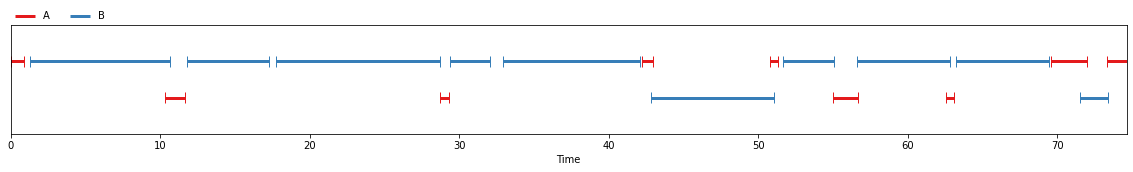

In [83]:
reference

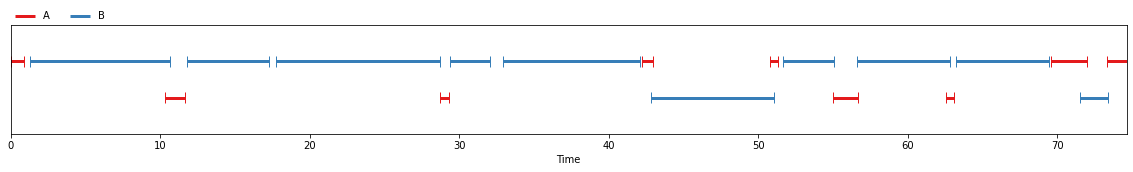

In [84]:
hypothesis